In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Activation, TimeDistributed, BatchNormalization
from keras.layers.merge import concatenate
from keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util.dataprep import get_vectors, get_data

import tensorflow as tf
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# To calculate on GPU
# https://github.com/tensorflow/tensorflow/issues/33721
TF_FORCE_GPU_ALLOW_GROWTH=1
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [3]:
# CONSTANTS
seed = 42
lr = 0.0001
batch = 32

Get my own dataset

In [4]:
cmt_pos = pd.read_csv('../../datasets/preprocessed data/stemmed/stem_pos.csv')
cmt_neg = pd.read_csv('../../datasets/preprocessed data/stemmed/stem_neg.csv')

In [5]:
X, Y, vocab_size, emdedding_size, vectors = get_data(cmt_pos, cmt_neg, 1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=seed, test_size=0.3, stratify=Y, shuffle=True)
# check if the data is evenly split
import collections
print('Train labels: ', collections.Counter(y_train))
print('Test labels: ', collections.Counter(y_test))

Train labels:  Counter({1: 2206, 0: 2206})
Test labels:  Counter({1: 946, 0: 946})


In [6]:
# Cross validation setup
sk = StratifiedKFold(n_splits = 3, random_state = seed, shuffle = True) 

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [8]:
adamOptimizer = Adam(lr=lr)

In [9]:
def plot_history(history_arrs, train, val, xlabel, ylabel, plot_title):
    if len(history_arrs) == 1:
        history = history_arrs[0]
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title(plot_title)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    else:
        f, a = plt.subplots(1, len(history_arrs), figsize=(10,5))
        for idx, history in enumerate(history_arrs):
            a[idx].plot(history[train])
            a[idx].plot(history[val])
            title = plot_title + ' ' + str(idx)
            a[idx].set_title(title)
            a[idx].set_xlabel(xlabel)
            a[idx].set_ylabel(ylabel)
            a[idx].legend(['Train', 'Validation'], loc='upper left')
        f.tight_layout()
        plt.show()

In [10]:
def model_1(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

In [11]:
def run_test(model_func, Xtrain, ytrain, X_test, y_test, embedding_layer):
    results = []
    histories = []
    best_model = None
    best_acc = 0
    for train_index, val_index in sk.split(X_train, y_train):
        Xt, Xv = Xtrain[train_index], Xtrain[val_index]
        yt, yv = ytrain[train_index], ytrain[val_index]
        model = model_func(embedding_layer)
        history = model.fit(Xt, yt, validation_data=(Xv, yv), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
        histories.append(history.history)
        loss, acc = model.evaluate(X_test, y_test, verbose=0, batch_size=batch)
        if best_acc < acc:
            best_model = model
        results.append([loss, acc])
    results = np.array(results)
    return results, histories, model

In [12]:
def calculate_metrics(model, X_test, y_test):
    ypred_class = model.predict_classes(X_test, verbose=0)
    ypred_class = ypred_class[:, 0]
    accuracy = accuracy_score(y_test, ypred_class)
    precision = precision_score(y_test, ypred_class)
    recall = recall_score(y_test, ypred_class)
    f1 = f1_score(y_test, ypred_class)
    conf_matrix = confusion_matrix(y_test, ypred_class)
    return accuracy, precision, recall, f1, conf_matrix

In [13]:
def print_conf_matrix(conf_matrix):
    cm = pd.DataFrame(
    conf_matrix, 
    index=['true:positive', 'true:negative'], 
    columns=['pred:positive', 'pred:negative']
    )
    print(cm)

# Model 1

First model cross-validation without pretrained word vectors

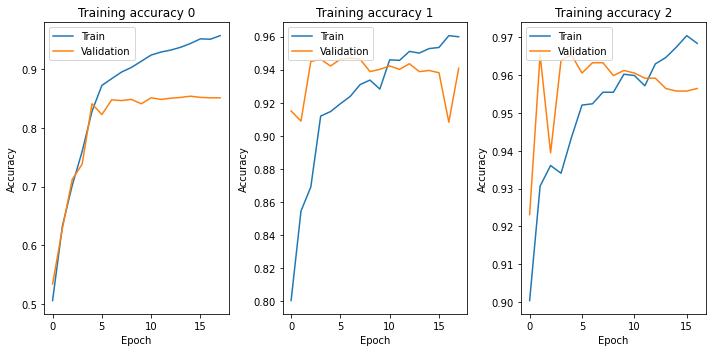

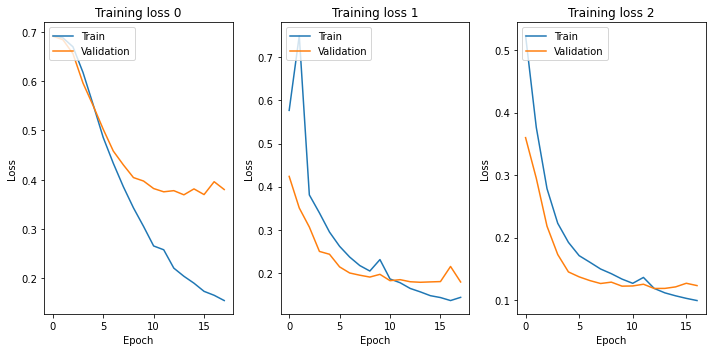

Average model 1 accuracy of cross validation on unseen data: 0.8744
The best perfoming model statistics with class predictions: 
Accuracy: 0.8832
Precision: 0.8836
Recall: 0.8827
F1 score: 0.8831
Confusion matrix:
               pred:positive  pred:negative
true:positive            836            110
true:negative            111            835


In [14]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
results, histories, model = run_test(model_1, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 1 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

First model evaluation without pretrained word vectors

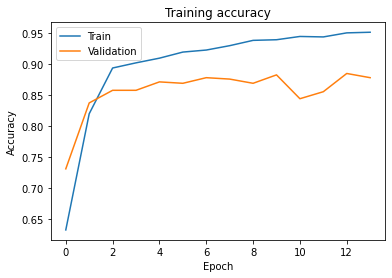

Model statistics with class predictions: 
Accuracy: 0.8837
Precision: 0.8813
Recall: 0.8869
F1 score: 0.8841
Confusion matrix:
               pred:positive  pred:negative
true:positive            833            113
true:negative            107            839


In [15]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
model = model_1(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [16]:
# Save the model (weights, architecture)
model.save('../../models/models/lstm-stemmed')

INFO:tensorflow:Assets written to: ../../models/models/lstm-stemmed\assets


INFO:tensorflow:Assets written to: ../../models/models/lstm-stemmed\assets


# Model 2

In [17]:
def model_2(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dropout(0.1))
    model.add(Dense(32))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer=adamOptimizer, metrics = ['accuracy'])
    return model

Second model cross-validation without pretrained word vectors

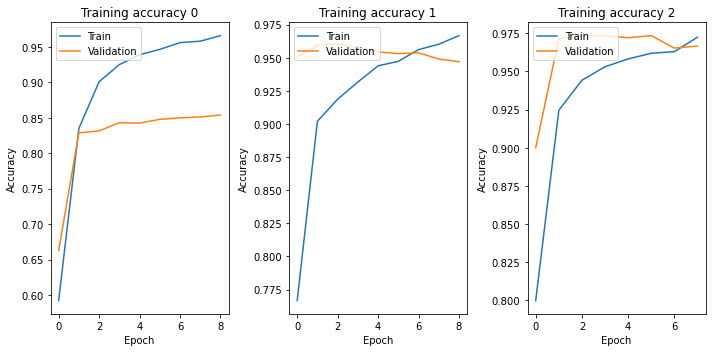

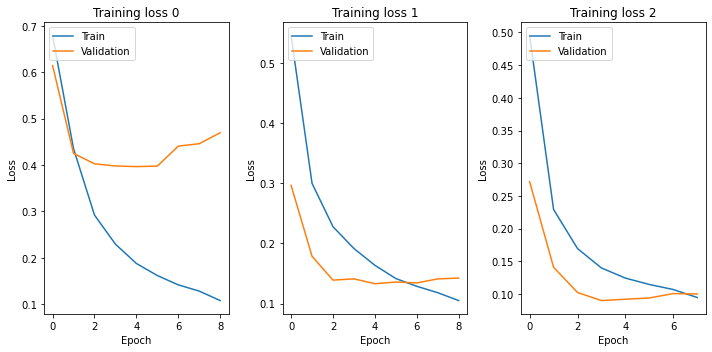

Average model 2 accuracy of cross validation on unseen data: 0.8719
The best perfoming model statistics with class predictions: 
Accuracy: 0.8768
Precision: 0.8813
Recall: 0.8710
F1 score: 0.8761
Confusion matrix:
               pred:positive  pred:negative
true:positive            835            111
true:negative            122            824


In [18]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
results, histories, model = run_test(model_2, X_train, y_train, X_test, y_test, embedding_layer)
# Plots
# Accuracy
plot_history(histories, 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy') 
# Loss
plot_history(histories, 'loss', 'val_loss', 'Epoch', 'Loss', 'Training loss')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Average model 2 accuracy of cross validation on unseen data: %.4f' % results[:, 1].mean())
print('The best perfoming model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

Second model evaluation without pretrained word vectors

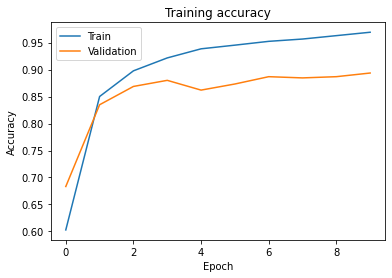

Model statistics with class predictions: 
Accuracy: 0.8726
Precision: 0.8507
Recall: 0.9038
F1 score: 0.8765
Confusion matrix:
               pred:positive  pred:negative
true:positive            796            150
true:negative             91            855


In [19]:
embedding_layer = Embedding(X.max()+1, 32, input_length=X.shape[1], trainable = True)
model = model_2(embedding_layer)
Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, random_state=seed, test_size=0.1, stratify=y_train, shuffle=True)
history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=30, batch_size=batch, verbose = 0, callbacks=[early_stopping])
plot_history([history.history], 'accuracy', 'val_accuracy', 'Epoch', 'Accuracy', 'Training accuracy')
acc, precision, recall, f1, conf_matrix = calculate_metrics(model, X_test, y_test)
print('Model statistics with class predictions: ')
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 score: %.4f' % f1)
print('Confusion matrix:')
print_conf_matrix(conf_matrix)

In [20]:
# Save best performing model (weights, architecture)
model.save('../../models/models/lstm2-stemmed')

INFO:tensorflow:Assets written to: ../../models/models/lstm2-stemmed\assets


INFO:tensorflow:Assets written to: ../../models/models/lstm2-stemmed\assets
